# Adding features to Human DNASU Data

## Loading packages

In [149]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import numpy as np
from mpl_toolkits import mplot3d
np.set_printoptions(threshold=sys.maxsize)
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
import statistics
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import RobustScaler
from scipy import stats
from scipy.stats import mannwhitneyu, fisher_exact
from scipy.stats import kurtosis
from scipy.stats import skew
from scipy.stats import norm
from statsmodels.stats.multitest import fdrcorrection
from sklearn import metrics

## Merging Human Features with DNASU Human proteins, Expression data and LHP Pred and splitting into train, test and validate

In [150]:
df = pd.read_csv("DNASU_HUMAN.csv", sep=',', index_col=0)
DNASU = df.copy()
df_drop = df.drop(['A', 'C', 'D', 'E','F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T','V', 'W', 'Y','Aromaticity', 'Instability_index','charge_at_7'], axis=1)
features = pd.read_csv("features_human_proteome_no_filtering.csv")
features.rename(columns = {'id':'UniprotID'}, inplace = True)
# features= features.drop(['A', 'C', 'D', 'E','F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T','V', 'W', 'Y','Aromaticity', 'Instability_index','charge_at_7'], axis=1)
# features.columns.values
df = df_drop.merge(features, on='UniprotID', how='left')
pd.set_option('display.max_rows', 500)
LP_pred = pd.read_csv("LHP_PREDICTIONS.tsv", sep='\t')
LP_pred.rename(columns = {'id':'UniprotID', 'prediction':'LHPpred'}, inplace = True)
df = df.merge(LP_pred, on='UniprotID', how='left')
Expression = pd.read_csv('ExpressionGenesAndUniprot.csv', index_col=0)
max_exp = Expression.groupby(['Gene','Gene_name', 'Uniprot_ID']).agg({'Tissue': lambda x: ",".join(x), 'NX':'max'}).rename({'NX' : 'max_NX'},axis=1).reset_index()
max_exp.rename(columns = {'Uniprot_ID':'UniprotID'}, inplace = True)
max_exp = max_exp.drop(["Tissue","Gene_name", "Gene"],axis=1 )
df = df.merge(max_exp, on='UniprotID', how='left')
df = df.select_dtypes(['number'])
original = df
df.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)
original.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)
new_df = df


In [151]:
len(new_df)
sum(DNASU["Binary_Solubility"])

DNASU

,Sequence,Binary_Solubility,id,Amino_acid_counts,Molecular_Weight,Flexibility,Aromaticity,Instability_index,Gravy_Score,Isoelectric_point,...,V,W,Y,Total_Residues,Proline_fraction,Cysteine_fraction,Turn_NPGS_fraction,UniprotID,Organism,HUMAN
0,MGHHHHHHSHMTFAAECLALNLCNQNIFCLGSSDVFVYSVGGVVLH...,0,80_DNASU,"{'A': 10, 'C': 6, 'D': 9, 'E': 12, 'F': 13, 'G...",22736.6469,"[0.9614166666666667, 0.961857142857143, 0.9615...",0.098522,41.780788,-0.089163,6.024274,...,13,2,5,203,0.039409,0.029557,0.266010,Q96RY7,HUMAN,1
1,MGHHHHHHSHMYRWVKWVRDGPTEGAQEELVLEVLRDGCRTAKVAL...,1,92_DNASU,"{'A': 12, 'C': 4, 'D': 6, 'E': 11, 'F': 5, 'G'...",17555.1484,"[0.9614166666666667, 0.961857142857143, 0.9615...",0.064103,38.989103,-0.314103,8.982009,...,13,2,3,156,0.057692,0.025641,0.192308,Q5T653,HUMAN,1
2,MGHHHHHHSHMVEEEEFLSNSTRRSKKLKAVEYARQIKDHLKANRL...,1,95_DNASU,"{'A': 51, 'C': 10, 'D': 26, 'E': 47, 'F': 22, ...",66803.4349,"[0.9614166666666667, 0.961857142857143, 0.9615...",0.073379,40.022526,-0.465700,8.985491,...,22,1,20,586,0.042662,0.017065,0.186007,O75127,HUMAN,1
3,MGHHHHHHSHMKTDCTDLARDEEALMVFSTLGGGLTAIDPVTSEIR...,0,96_DNASU,"{'A': 15, 'C': 2, 'D': 18, 'E': 11, 'F': 5, 'G...",25896.8881,"[0.9614166666666667, 0.961857142857143, 0.9615...",0.091304,33.468304,-0.564783,6.104076,...,12,5,11,230,0.056522,0.008696,0.221739,O75460,HUMAN,1
4,MGHHHHHHSHMVISAVCEKVFSWFSLQCEGGSSVSLPESLLFVSTL...,0,117_DNASU,"{'A': 14, 'C': 4, 'D': 18, 'E': 18, 'F': 12, '...",36942.2191,"[0.9614166666666667, 0.961857142857143, 0.9615...",0.106383,50.889696,-0.375380,6.044850,...,23,7,16,329,0.048632,0.012158,0.240122,O75460,HUMAN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2814,MPTCSTQETPNTDINAITQQVEQWLNDVVIGLNLCPFAAKPQRNKQ...,1,11995_DNASU,"{'A': 10, 'C': 4, 'D': 12, 'E': 22, 'F': 10, '...",23386.0871,"[0.9979523809523808, 1.0240595238095238, 1.035...",0.094527,51.636318,-0.447761,4.683897,...,11,4,5,201,0.069652,0.019900,0.184080,P51689,HUMAN,1
2815,MLKWLIIALFIASALYIHYRGRVRHRLSRQLLDHSTFMAPINTLMY...,1,12073_DNASU,"{'A': 19, 'C': 3, 'D': 11, 'E': 8, 'F': 11, 'G...",23536.8489,"[0.9512619047619049, 0.9473452380952381, 0.954...",0.113300,37.177389,-0.324631,9.466296,...,5,6,6,203,0.068966,0.014778,0.192118,Q6ICH7,HUMAN,1
2816,MLKWLIIALFIASALYIHYRGRVRHRLSRQLLDHSTFMAPINTLMY...,1,12075_DNASU,"{'A': 29, 'C': 5, 'D': 17, 'E': 12, 'F': 17, '...",35855.9528,"[0.9512619047619049, 0.9473452380952381, 0.954...",0.116505,36.232751,-0.297735,9.674335,...,13,9,10,309,0.055016,0.016181,0.187702,Q12797,HUMAN,1
2817,MRMNIRVALPQAQVHWCRGWLQAAHADALMQALLDQVQWEVHRIRM...,1,12130_DNASU,"{'A': 21, 'C': 1, 'D': 12, 'E': 8, 'F': 6, 'G'...",23873.8556,"[0.9902142857142857, 0.9619880952380953, 0.986...",0.076555,37.936364,-0.474641,9.782578,...,15,6,4,209,0.047847,0.004785,0.191388,Q6NS38,HUMAN,1


## Correlation plots 

### LHP pred vs Solubility 

p = 0.000000
skewness = 4.770180
kurtosis = 31.320817


[Text(0, 0, 'Soluble'), Text(1, 0, 'Non-Soluble')]

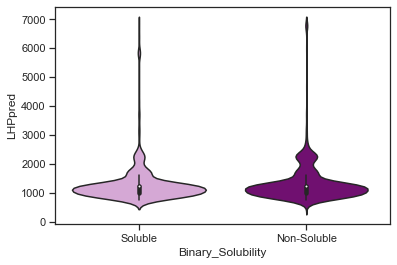

In [152]:
k2, p = stats.normaltest(df["LHPpred"], nan_policy = "omit")
print("p = {:f}".format(p))
print("skewness = {:f}".format(skew(df["LHPpred"], nan_policy = "omit")))
print("kurtosis = {:f}".format(kurtosis(df["LHPpred"], nan_policy = "omit")))
my_pal = {0: "plum", 1: "purple"}
ax = sns.violinplot(x='Binary_Solubility', y="LHPpred", data=df, palette=my_pal, showmeans=True, )
ax.set_xticklabels(["Soluble",'Non-Soluble'])

Text(0.5, 0, 'LHP predictions')

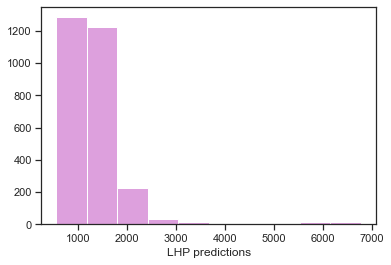

In [153]:
plt.hist(df["LHPpred"], color = "plum")
plt.xlabel("LHP predictions")

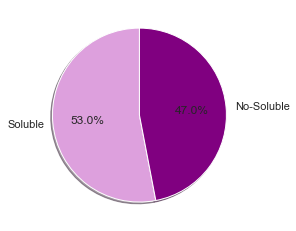

In [154]:
part = np.array((df["Binary_Solubility"].sum()/(len(df["Binary_Solubility"])), 1- (df["Binary_Solubility"].sum()/(len(df["Binary_Solubility"])))))
labels = ["Soluble", "No-Soluble"]
colors = ["plum", "purple"]
plt.pie(part, labels= labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90)
plt.show()

### Expression vs Solubility 

p = 0.000000
skewness = 6.564983
kurtosis = 65.708477


[Text(0, 0, 'Soluble'), Text(1, 0, 'Non-Soluble')]

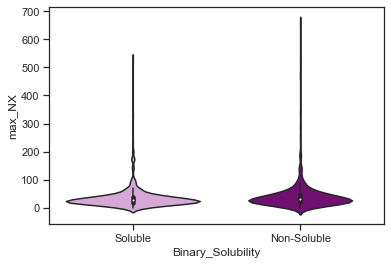

In [155]:
k2, p = stats.normaltest(df['max_NX'], nan_policy = "omit")
print("p = {:f}".format(p))
print("skewness = {:f}".format(skew(df['max_NX'], nan_policy = "omit")))
print("kurtosis = {:f}".format(kurtosis(df['max_NX'], nan_policy = "omit")))
my_pal = {0: "plum", 1: "purple"}
ax = sns.violinplot(x='Binary_Solubility', y='max_NX', data=df, palette=my_pal)
ax.set_xticklabels(["Soluble",'Non-Soluble'])


Text(0.5, 0, 'Max Normalised Expression')

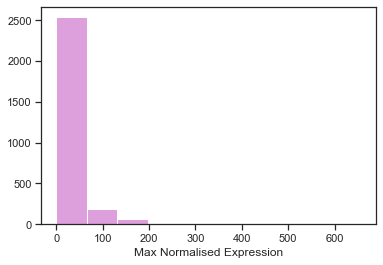

In [156]:
plt.hist(df['max_NX'], color = "plum")
plt.xlabel("Max Normalised Expression")

### 3D plot of log(max_expression), LHP predictions, Aggregation propensity and Solubility

/Users/priya/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


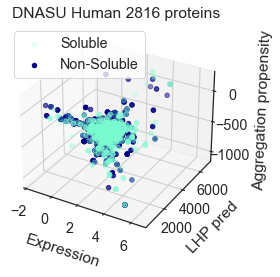

In [157]:
sns.set(style=("white"), font_scale=1.3)
marker_size=15
fig = plt.figure()
ax = plt.axes(projection='3d')
sol = df.loc[df['Binary_Solubility'] == 1]
ag = df.loc[df['Binary_Solubility'] == 0]
ax.scatter3D(np.log(sol['max_NX']) , sol['LHPpred'], sol['Aggregation_propensity'], c='aquamarine', alpha =0.2)
ax.scatter3D(np.log(ag['max_NX']) , ag['LHPpred'], ag['Aggregation_propensity'], c='navy')
ax.set_xlabel("Expression", labelpad=10)
ax.set_ylabel("LHP pred",labelpad=10)
ax.set_zlabel("Aggregation propensity",labelpad=10)
ax.legend(["Soluble", "Non-Soluble"])
ax.set_title("DNASU Human 2816 proteins")
plt.savefig('Figures/3Dplot.png', dpi=300, bbox_inches='tight')
plt.show()

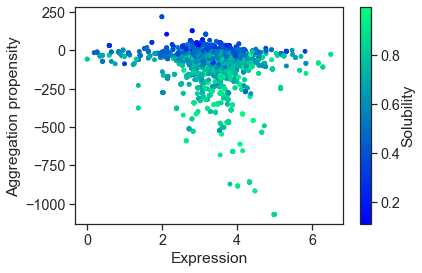

In [158]:
marker_size=15
sns.set(style=("ticks"),font_scale=1.3)
plt.scatter(np.log(df['max_NX']+1),df['Aggregation_propensity'] , marker_size, c=df['Prob. of Solubility'], cmap = "winter" )
plt.xlabel("Expression")
plt.ylabel("Aggregation propensity")
cbar= plt.colorbar()
cbar.set_label("Solubility", labelpad=+1)
plt.savefig('Figures/2Dplot.png',dpi=300, bbox_inches='tight')
plt.show()

### Correlation between Max_expression, LHP predictions, Aggregation propensity and Solubility

/var/folders/3j/bhbg34qd24553j30j22dbny40000gn/T/ipykernel_6592/3357150944.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool),square=False, ax=ax)


Text(0.5, 1.0, 'DNASU human protein data')

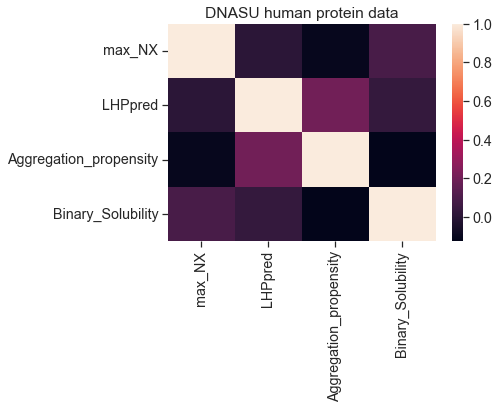

In [159]:
df_corr = df.filter(['max_NX' , 'LHPpred', 'Aggregation_propensity', 'Binary_Solubility' ],axis=1)
corr = df_corr.corr()
ax = plt.axes()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool),square=False, ax=ax)
ax.set_title('DNASU human protein data')

## Machine learning

#### Selecting the features and scaling them

In [160]:
seq_features = ['Binary_Solubility','length', 'hydr_count', 'polar_count', 'molecular_weight', 'helix', 'turn', 'sheet', 'A', 'C', 'D', 'E', 'F', 
                'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', 'thsa_netsurfp2', 'tasa_netsurfp2', 
                'rhsa_netsurfp2', 'disorder', 'A_exposed', 'C_exposed', 'D_exposed', 'E_exposed', 'F_exposed',
                'G_exposed', 'H_exposed', 'I_exposed', 'K_exposed', 'L_exposed', 'M_exposed', 'N_exposed', 'P_exposed', 
                'Q_exposed', 'R_exposed', 'S_exposed', 'T_exposed', 'V_exposed', 'W_exposed', 'Y_exposed', 
                'Aggregation_propensity', 'Aromaticity', 'Instability_index', 'Gravy', 
                'isoelectric_point', 'charge_at_7', 'charge_at_5', 'PTM_MSD', 'Phosphorylation_MSD',
                'Glycosylation_MSD', 'Ubiquitination_MSD', 'SUMOylation_MSD', 'Acetylation_MSD', 'Palmitoylation_MSD', 
                'Methylation_MSD', 'Polar_exposed', 'Hydrophobic_exposed','LHPpred','max_NX']

len(seq_features)

71

In [161]:
def get_normalised_df(df):
    df_min_max_scaled = df.copy()
    # apply normalization to all columns
    for column in df_min_max_scaled:
        if column != 'Binary_Solubility':
            df_min_max_scaled[column] = (df_min_max_scaled[column] - df_min_max_scaled[column].min()) / (df_min_max_scaled[column].max() - df_min_max_scaled[column].min())    
    return df_min_max_scaled


In [162]:
Final_DNASU_ML = get_normalised_df(new_df)#TRAINING DATASET

#### Splitting data into train, test and validate

In [163]:
# Final_DNASU_ML = Final_DNASU_ML.drop(["HUMAN", "GPI-anchor_UP","Prob. of Solubility"], axis = 1)
df_train, df_test_val = train_test_split(Final_DNASU_ML, test_size=0.2)
df_test, df_val = train_test_split(df_test_val, test_size=0.5)
df_train =df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

In [164]:
x_train, x_test, y_train, y_test = train_test_split(Final_DNASU_ML.drop('Binary_Solubility', axis = 1), Final_DNASU_ML['Binary_Solubility'],test_size=0.2,random_state=0,stratify=Final_DNASU_ML['Binary_Solubility'])
# df_train, df_test_val = train_test_split(Final_DNASU_ML, test_size=0.2)
x_test, x_validate, y_test, y_validate = train_test_split(x_test, y_test,test_size=0.5,random_state=0,stratify=y_test)
df_train = pd.concat([y_train,x_train], axis =1).reset_index(drop=True)
df_test = pd.concat([y_test,x_test], axis =1).reset_index(drop=True)
df_val = pd.concat([y_validate,x_validate], axis =1).reset_index(drop=True)
df_train

,Binary_Solubility,Molecular_Weight,Gravy_Score,Isoelectric_point,Mean_flexibility,Total_Residues,Proline_fraction,Cysteine_fraction,Turn_NPGS_fraction,HUMAN,...,EGF,RAS_profile,RRM,ww_domain,transmembrane,TMHMM,Polar_exposed,Hydrophobic_exposed,LHPpred,max_NX
0,1,0.235089,0.692958,0.302705,0.403983,0.237864,0.277809,0.038710,0.629068,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.680556,0.175680,0.072305,0.025582
1,1,0.090127,0.636208,0.075553,0.656760,0.088997,0.183236,0.000000,0.540144,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.495440,0.307966,0.109560,0.021776
2,1,0.108275,0.831717,0.342898,0.212162,0.113269,0.210693,0.132110,0.511170,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.467014,0.246166,0.062492,0.044922
3,0,0.631805,0.625445,0.630148,0.349952,0.616505,0.300739,0.120000,0.511771,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.700680,0.140736,0.109560,0.038526
4,0,0.263890,0.883551,0.489612,0.238721,0.273463,0.138014,0.103846,0.598374,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.707968,0.095074,0.050818,0.046901
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2247,1,0.054916,0.419717,0.250605,0.536748,0.059871,0.226633,0.757895,0.485308,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.351250,0.446680,0.269199,0.077052
2248,0,0.182018,0.598388,0.289731,0.527070,0.168285,0.120449,0.050350,0.413779,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.843583,0.078588,0.050818,0.043094
2249,1,0.227533,0.539876,0.083220,0.680978,0.221683,0.097864,0.000000,0.512765,NaN,...,0.0,0.0,0.0,0.0,1.0,0.0,0.716270,0.306582,0.222844,0.025887
2250,1,0.444248,0.811080,0.611925,0.346300,0.435275,0.354176,0.070130,0.507797,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.696756,0.181537,0.109560,0.059845


In [165]:
sum(df_train["Binary_Solubility"])
sum(df_test["Binary_Solubility"])
sum(df_val["Binary_Solubility"])

149

In [166]:
df_train = df_train[seq_features]
df_test = df_test[seq_features]
df_val_copy = df_val
df_val = df_val[seq_features]

In [167]:
#Labels are the values to be predicted, in this case the solubility
Train_labels = np.array(df_train['Binary_Solubility'])

# Remove the labels from the features
Train_features= df_train.drop('Binary_Solubility', axis = 1)

# Saving feature names for later use
Train_feature_list = list(Train_features.columns)

# Convert to numpy array
Train_features = np.array(Train_features)
# Train_features = RobustScaler().fit_transform(Train_features)


#Same thing for test set
Test_labels = np.array(df_test['Binary_Solubility'])
Test_features = df_test.drop('Binary_Solubility', axis = 1)
Test_feature_list = list(Test_features.columns)
Test_features = np.array(Test_features)
# Test_features = RobustScaler().fit_transform(Test_features)

#And the cleaned test set
Test_labels2 = np.array(df_val['Binary_Solubility'])
Test_features2 = df_val.drop('Binary_Solubility', axis = 1)
Test_feature_list2 = list(Test_features2.columns)
Test_features2 = np.array(Test_features2)
# Test_features2 = RobustScaler().fit_transform(Test_features2)

#Check shape of train and test
print('Training Features Shape:', Train_features.shape)
print('Training Labels Shape:', Train_labels.shape)
print('Testing Features Shape:', Test_features.shape)
print('Testing Labels Shape:', Test_labels.shape)
print('Cleaned testing Features Shape:', Test_features2.shape)
print('Cleaned testing Labels Shape:', Test_labels2.shape)


Training Features Shape: (2252, 70)
Training Labels Shape: (2252,)
Testing Features Shape: (282, 70)
Testing Labels Shape: (282,)
Cleaned testing Features Shape: (282, 70)
Cleaned testing Labels Shape: (282,)


## Training the Model and predicting solubility

In [168]:
Final_DNASU_ML.describe()

,Binary_Solubility,Molecular_Weight,Gravy_Score,Isoelectric_point,Mean_flexibility,Total_Residues,Proline_fraction,Cysteine_fraction,Turn_NPGS_fraction,HUMAN,...,EGF,RAS_profile,RRM,ww_domain,transmembrane,TMHMM,Polar_exposed,Hydrophobic_exposed,LHPpred,max_NX
count,2816.000000,2816.000000,2816.000000,2816.000000,2816.000000,2816.000000,2816.000000,2816.000000,2816.000000,0.0,...,2816.000000,2816.000000,2816.000000,2816.000000,2816.000000,2816.000000,2816.000000,2816.000000,2816.000000,2816.000000
mean,0.530185,0.288917,0.661489,0.400382,0.437729,0.286326,0.244967,0.154405,0.546233,NaN,...,0.004616,0.005327,0.008168,0.007457,0.132102,0.037997,0.590796,0.291645,0.120789,0.058122
std,0.499177,0.196199,0.134989,0.196381,0.137476,0.194095,0.122181,0.136986,0.126282,NaN,...,0.067800,0.072803,0.090021,0.086049,0.338662,0.191223,0.174088,0.139301,0.106382,0.066092
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.135857,0.583675,0.252575,0.346873,0.134304,0.168864,0.067500,0.462511,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.481427,0.194867,0.067386,0.028476
50%,1.000000,0.233850,0.679777,0.334679,0.426887,0.231392,0.239224,0.126316,0.547909,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.608400,0.280372,0.109560,0.043551
75%,1.000000,0.388998,0.753819,0.585534,0.519732,0.383495,0.309739,0.197260,0.625326,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.713964,0.379870,0.109560,0.065669
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [169]:
#Support vector
svc = SVC(random_state=42)
svc.fit(Train_features, Train_labels)

#random forest
rf = RandomForestClassifier(n_estimators = 100, bootstrap = True, max_features = 'sqrt')
rf.fit(Train_features, Train_labels)

#Logistic regression
lr = LogisticRegression(max_iter = 1000)
lr.fit(Train_features, Train_labels)

LogisticRegression(max_iter=1000)

In [170]:
# Use the forest's predict method on the test data
rf_predictions = rf.predict(Test_features)

# Probabilities for each class
rf_probs = rf.predict_proba(Test_features)[:, 1]

#same for cleaned test set
rf_predictions2 = rf.predict(Test_features2)
rf_probs2 = rf.predict_proba(Test_features2)[:, 1]

In [171]:
# Calculate roc auc 
roc_value = roc_auc_score(Test_labels, rf_probs)
print('AUC:', roc_value)

#same for cleaned
roc_value = roc_auc_score(Test_labels2, rf_probs2)
print('AUC:', roc_value)

AUC: 0.8303282828282829
AUC: 0.8493212898016855


In [172]:
def get_AUC(model, x_train, x_test, y_train, y_test):
    rf = model.fit(x_train, y_train)
    rf_predictions = rf.predict(x_test)
    rf_probs = rf.predict_proba(x_test)[:, 1]
    roc_value = roc_auc_score(y_test, rf_probs)
    return roc_value

### Feature importance 

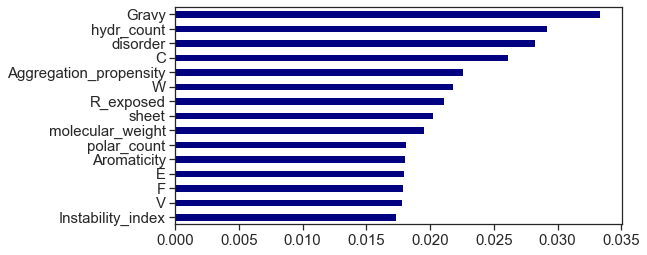

In [173]:
# Extract feature importances
fi = pd.DataFrame({'feature': (Train_feature_list),
                   'importance': rf.feature_importances_}).\
                    sort_values('importance', ascending = True)

# Display
fi
top_20 = fi[:-20]


feature_importance = pd.Series(index = df_train.drop('Binary_Solubility', axis = 1).columns.values, data = rf.feature_importances_)
feature_importance.sort_values(ascending = True)[55:].plot(kind='barh',  figsize=(8,4), color="navy", fontsize=15)
fig = plt.gcf()
plt.savefig('Figures/featureImportance.png', dpi=300, bbox_inches='tight')


# .sort_values("feature", ascending = True)

### ROC curves 

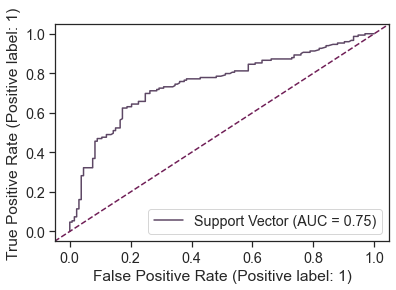

In [174]:
sns.set_palette("rocket")
ax = plt.gca()
svc_disp2 = plot_roc_curve(svc, Test_features2, Test_labels2,name='Support Vector', ax=ax, alpha=0.8)
ax.plot([0, 1], [0, 1],linestyle='--', transform=ax.transAxes)
plt.show()

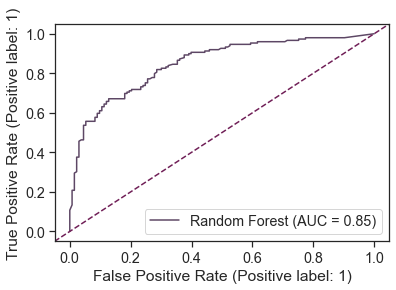

In [175]:
ax = plt.gca()
rf_disp2 = plot_roc_curve(rf, Test_features2, Test_labels2,name='Random Forest', ax=ax, alpha=0.8)
ax.plot([0, 1], [0, 1],linestyle='--', transform=ax.transAxes)
plt.show()

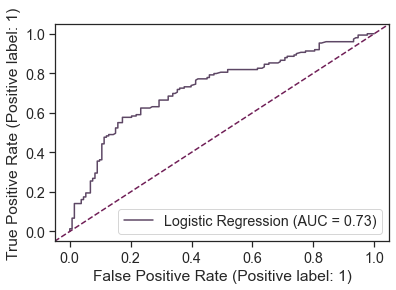

In [176]:
ax = plt.gca()
svc_disp2 = plot_roc_curve(lr, Test_features2, Test_labels2,name='Logistic Regression', ax=ax, alpha=0.8)
ax.plot([0, 1], [0, 1],linestyle='--', transform=ax.transAxes)
plt.show()

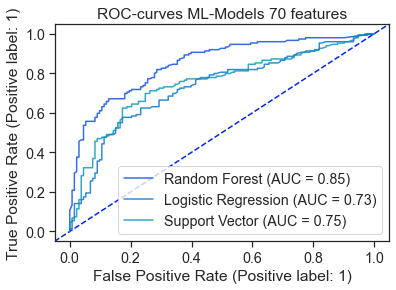

In [177]:
sns.set_palette("winter")
ax = plt.gca()
ax.plot([0, 1], [0, 1],linestyle='--', transform=ax.transAxes)
rf_disp = plot_roc_curve(rf, Test_features2, Test_labels2,name='Random Forest', ax=ax, alpha=0.8)
lr_disp = plot_roc_curve(lr, Test_features2, Test_labels2,name='Logistic Regression', ax=ax, alpha=0.8)
svc_disp = plot_roc_curve(svc, Test_features2, Test_labels2,name='Support Vector', ax=ax, alpha=0.8)
plt.title('ROC-curves ML-Models 70 features')
plt.savefig('Figures/ROC.png', dpi=300, bbox_inches='tight')
plt.show()

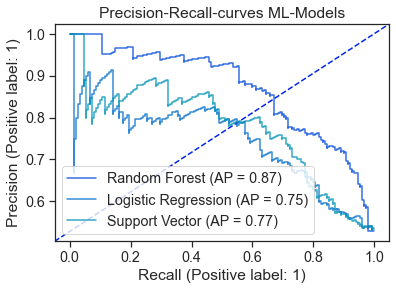

In [178]:
sns.set_palette("winter")
ax = plt.gca()
ax.plot([0, 1], [0, 1],linestyle='--', transform=ax.transAxes)
rf_disp = plot_precision_recall_curve(rf, Test_features2, Test_labels2,name='Random Forest', ax=ax, alpha=0.8)
lr_disp = plot_precision_recall_curve(lr, Test_features2, Test_labels2,name='Logistic Regression', ax=ax, alpha=0.8)
svc_disp = plot_precision_recall_curve(svc, Test_features2, Test_labels2,name='Support Vector', ax=ax, alpha=0.8)
plt.title('Precision-Recall-curves ML-Models')
plt.savefig('Figures/PRC.png', dpi=300, bbox_inches='tight')
plt.show()

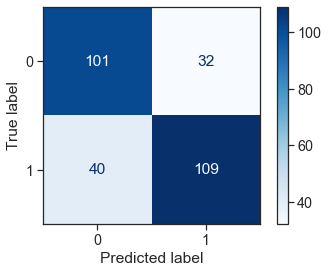

In [179]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(Test_labels2,rf_predictions2)
cm_display = ConfusionMatrixDisplay(cm).plot(cmap="Blues")
plt.savefig('Figures/ConfusionMatrix.png', dpi=300, bbox_inches='tight')

In [180]:
from sklearn.metrics import f1_score, matthews_corrcoef, fowlkes_mallows_score
print(f1_score(Test_labels2,rf_predictions2))
print(matthews_corrcoef(Test_labels2,rf_predictions2))
print(fowlkes_mallows_score(Test_labels2,rf_predictions2))

0.7517241379310345
0.49015127428777155
0.6176419175589093


## Stratified 10- fold cross validation: AUC

In [181]:
from sklearn.model_selection import train_test_split
SOLtarget = np.array(df_train['Binary_Solubility'])
SOLdata = np.array(Train_features)

In [182]:
def get_score(model, x_train, x_test, y_train, y_test):
    model.fit(x_train, y_train)
    return model.score(x_test, y_test)

In [183]:
from sklearn.model_selection import StratifiedKFold
kf = StratifiedKFold(n_splits = 10)

In [184]:
AUC_rf = []
for train_index,test_index in kf.split(SOLdata, SOLtarget):
    x_train, x_test, y_train, y_test = SOLdata[train_index], SOLdata[test_index], \
                                        SOLtarget[train_index], SOLtarget[test_index]
    model = LogisticRegression(max_iter = 1000)
    AUC_rf.append(get_AUC(model, x_train, x_test, y_train, y_test))
print("Mean AUC score:")
print(np.mean(AUC_rf))

Mean AUC score:
0.6601589173405211


In [185]:
print(np.mean(cross_val_score(LogisticRegression(max_iter = 1000),SOLdata,SOLtarget,scoring= 'roc_auc',cv=10)))
print(np.mean(cross_val_score(SVC(),SOLdata,SOLtarget,scoring= 'roc_auc',cv=10)))
print(np.mean(cross_val_score(RandomForestClassifier(n_estimators = 100),SOLdata,SOLtarget,scoring= 'roc_auc',cv=10)))

0.6601589173405211
0.693370820340715
0.7647053582439265


In [38]:
roc_rf = cross_val_score(RandomForestClassifier(n_estimators = 100),SOLdata,SOLtarget,scoring= 'roc_auc',cv=10)
f1_rf =cross_val_score(RandomForestClassifier(n_estimators = 100),SOLdata,SOLtarget,scoring= 'f1',cv=10)
acc_rf =cross_val_score(RandomForestClassifier(n_estimators = 100),SOLdata,SOLtarget,scoring= 'accuracy',cv=10)
bacc_rf =cross_val_score(RandomForestClassifier(n_estimators = 100),SOLdata,SOLtarget,scoring= 'balanced_accuracy',cv=10)
precision_rf =cross_val_score(RandomForestClassifier(n_estimators = 100),SOLdata,SOLtarget,scoring= 'precision',cv=10)
recall_rf =cross_val_score(RandomForestClassifier(n_estimators = 100),SOLdata,SOLtarget,scoring= 'recall',cv=10)

df_roc_rf = pd.DataFrame(roc_rf, columns=["score"])
df_f1_rf =pd.DataFrame(f1_rf, columns=["score"])
df_acc_rf =pd.DataFrame(acc_rf, columns=["score"])
df_bacc_rf =pd.DataFrame(bacc_rf, columns=["score"])
df_precision_rf =pd.DataFrame(precision_rf, columns=["score"])
df_recall_rf = pd.DataFrame(recall_rf, columns=["score"])

df_roc_rf['metric'] = 'AUC'
df_f1_rf['metric'] = 'F1'
df_acc_rf['metric'] = 'ACC'
df_bacc_rf['metric'] = 'BACC'
df_precision_rf['metric'] = 'Precision'
df_recall_rf['metric'] = 'Recall'

df_roc_rf['model'] = 'Solubility'
df_f1_rf['model'] = 'Solubility'
df_acc_rf['model'] = 'Solubility'
df_bacc_rf['model'] = 'Solubility'
df_precision_rf['model'] = 'Solubility'
df_recall_rf['model'] = 'Solubility'

df_scores = pd.concat([df_roc_rf, df_f1_rf, df_acc_rf,df_bacc_rf, df_precision_rf, df_recall_rf])
df_scores
df_scores.to_csv('SolubilityScores.csv')


In [39]:
# LR = cross_val_score(LogisticRegression(max_iter = 10000),SOLdata,SOLtarget,scoring= 'roc_auc',cv=10)
# SVM = cross_val_score(SVC(),SOLdata,SOLtarget,scoring= 'roc_auc',cv=10)
# RF = cross_val_score(RandomForestClassifier(n_estimators = 100),SOLdata,SOLtarget,scoring= 'roc_auc',cv=10)

# mean_LR = np.mean(LR)
# mean_SVM = np.mean(SVM)
# mean_RF = np.mean(RF)

# std_LR = np.std(LR)
# std_SVM = np.std(SVM)
# std_RF = np.std(RF)

# labels = ['Logistic Regression', 'Support Vector Machine', 'Random Forest']
# x_pos = np.arange(len(labels))

# means = [mean_LR, mean_SVM, mean_RF]
# stds = [std_LR, std_SVM, std_RF]

# fig, ax = plt.subplots()
# ax.bar(x_pos, means, yerr=stds, align='center', ecolor='black',alpha = 0.5, capsize=15, color="purple")
# ax.set_xticks(x_pos)
# ax.set_xticklabels(labels)
# ax.set_title("10-fold cross-validation")
# ax.yaxis.grid(True)
# plt.savefig('Figures/10FoldBarplot.png', dpi=300, bbox_inches='tight')

In [40]:
d = {'Model': ['Logistic Regression', 
                   'Support Vector', 'Random Forest'],
        'AUC':[0.7536441185491111, 0.7692220503043901, 0.8368065057148513]}
df = pd.DataFrame(data=d)

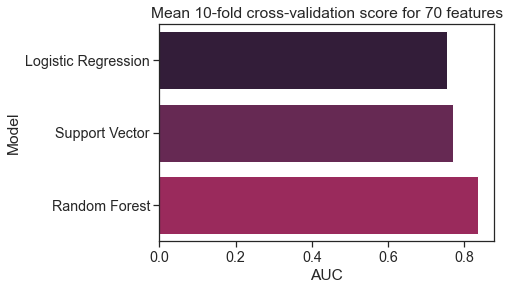

In [41]:
# sns.set(style=("ticks"), font_scale=1.5)
sns.set_palette("rocket")
ax = sns.barplot(x="AUC", y="Model", data=df, ).set_title('Mean 10-fold cross-validation score for 70 features')


## Testing how significant features are 

In [186]:
features_continuous = ['length', 'hydr_count', 'polar_count', 'molecular_weight',
       'helix', 'turn', 'sheet', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K',
       'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', 'thsa_netsurfp2',
       'tasa_netsurfp2', 'rhsa_netsurfp2', 'disorder', 'A_exposed',
       'C_exposed', 'D_exposed', 'E_exposed', 'F_exposed', 'G_exposed',
       'H_exposed', 'I_exposed', 'K_exposed', 'L_exposed', 'M_exposed',
       'N_exposed', 'P_exposed', 'Q_exposed', 'R_exposed', 'S_exposed',
       'T_exposed', 'V_exposed', 'W_exposed', 'Y_exposed',
        'Aggregation_propensity', 'Aromaticity',
       'Instability_index', 'Gravy', 'isoelectric_point', 'charge_at_7',
       'charge_at_5', 'Polar_exposed', 'Hydrophobic_exposed','LHPpred']

features_categorical = ['PTM_MSD', 'Phosphorylation_MSD',
       'Glycosylation_MSD', 'Ubiquitination_MSD', 'SUMOylation_MSD',
       'Acetylation_MSD', 'Palmitoylation_MSD', 'Methylation_MSD']

sol = df_train[df_train["Binary_Solubility"] == 1]
non_sol = df_train[df_train["Binary_Solubility"] == 0]

## Mann-Whitney U test 

In [187]:
# create Series to save p-values
p_vals = pd.Series(index=features_continuous, dtype="float64", name='p_value')

# calculate p-values using Mann-Whitney U Test
for i, feature in enumerate(features_continuous):
    stat, p = mannwhitneyu(sol[feature], non_sol[feature]) # function returns statistic and p-value
    p_vals[i] = p 

# calculate adjusted p-value (FDR correction)
rejected, p_vals_adj = fdrcorrection(p_vals)
# create Series to save adjusted p-values
p_vals_adj = pd.Series(data=p_vals_adj, index=features_continuous, name='p_value_adjusted')

In [188]:
# save both p-values in dataframe
p_vals_comb = pd.concat([p_vals, p_vals_adj], axis=1)
# sort by adjusted p-value
p_vals_comb = p_vals_comb.sort_values(by='p_value_adjusted')

In [189]:
# print adjusted p-values (readable)
for i in range(len(p_vals_comb)):
    print(p_vals_comb.index[i], 'p=%.5f' % (p_vals_comb.p_value_adjusted[i]))

Gravy p=0.00000
hydr_count p=0.00000
disorder p=0.00000
Aggregation_propensity p=0.00000
Aromaticity p=0.00000
W p=0.00000
C p=0.00000
F p=0.00000
sheet p=0.00000
Hydrophobic_exposed p=0.00000
polar_count p=0.00000
E p=0.00000
L p=0.00000
turn p=0.00000
V p=0.00000
R_exposed p=0.00000
L_exposed p=0.00000
Polar_exposed p=0.00000
Instability_index p=0.00000
V_exposed p=0.00001
I p=0.00002
I_exposed p=0.00014
K p=0.00014
D_exposed p=0.00024
A_exposed p=0.00025
F_exposed p=0.00047
S p=0.00047
charge_at_5 p=0.00047
Y p=0.00054
molecular_weight p=0.00290
H_exposed p=0.00312
Q p=0.00313
length p=0.00369
E_exposed p=0.00518
M_exposed p=0.00638
A p=0.00720
S_exposed p=0.01216
isoelectric_point p=0.01650
H p=0.02067
Y_exposed p=0.04380
D p=0.04927
N_exposed p=0.04968
charge_at_7 p=0.05970
Q_exposed p=0.08800
helix p=0.11107
rhsa_netsurfp2 p=0.11124
LHPpred p=0.11761
M p=0.20397
K_exposed p=0.21065
T p=0.21065
C_exposed p=0.23748
P p=0.24074
thsa_netsurfp2 p=0.24835
N p=0.26136
tasa_netsurfp2 p=0

## Fishers Exact test

In [190]:
# create Series to save p-values
p_vals_cat = pd.Series(index=features_categorical, dtype="float64", name='p_value')

# calculate p-values using Fisher's exact test
for i, feature in enumerate(features_categorical):
    
    # get counts for each category
    A = sum(sol[feature]) 
    B = len(sol[feature]) - sum(sol[feature]) 
    C = sum(non_sol[feature]) 
    D = len(non_sol[feature]) - sum(non_sol[feature])
    
    # create 2x2 contingency table of counts
    table = np.array([[A, B],
                      [C, D]])
    
    odds, p = fisher_exact(table, alternative='two-sided') # function returns odds ratio and p-value
    p_vals_cat[i] = p 

# calculate adjusted p-value (FDR correction)
rejected, p_vals_adj_cat = fdrcorrection(p_vals_cat)
# create Series to save adjusted p-values
p_vals_adj_cat = pd.Series(data=p_vals_adj_cat, index=features_categorical, name='p_value_adjusted')


In [191]:
# save both p-values in dataframe
p_vals_comb_cat = pd.concat([p_vals_cat, p_vals_adj_cat], axis=1)
# sort by adjusted p-value
p_vals_comb_cat = p_vals_comb_cat.sort_values(by='p_value_adjusted')

In [192]:
# print adjusted p-values (readable)
for i in range(len(p_vals_comb_cat)):
    print(p_vals_comb_cat.index[i], 'p=%.5f' % (p_vals_comb_cat.p_value_adjusted[i]))


SUMOylation_MSD p=0.07026
Acetylation_MSD p=0.08989
PTM_MSD p=0.22478
Palmitoylation_MSD p=0.33116
Glycosylation_MSD p=0.49199
Phosphorylation_MSD p=0.73476
Ubiquitination_MSD p=0.73476
Methylation_MSD p=0.73476


In [193]:
sns.set(style=("ticks"), font_scale=4)
x1, x2= 0, 1
dataset = new_df
labels = ['Soluble',"Non-Soluble"]

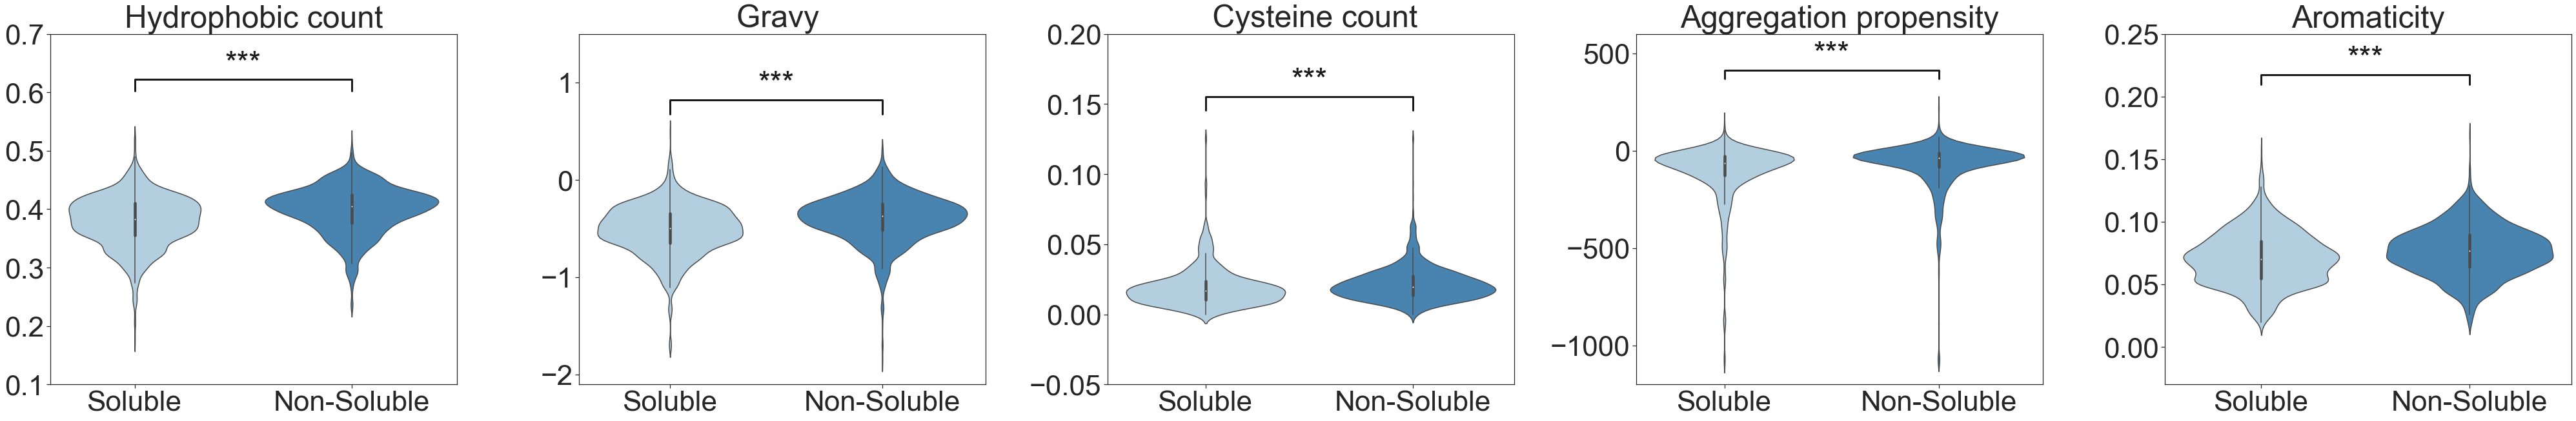

In [194]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, sharey=False, figsize=(70, 10))

sns.violinplot(x="Binary_Solubility", y="hydr_count", data=dataset, ax=ax1, order=[1, 0], palette="Blues")
ax1.set(ylabel=None, xlabel=None, title="Hydrophobic count", xticklabels=(labels),ylim=(0.1,0.7))
y, h, col = dataset["hydr_count"].max() + 0.08, 0.02, 'k'
ax1.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=3, c=col)
ax1.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)

sns.violinplot(x="Binary_Solubility", y="Gravy", data=dataset, ax=ax2, order=[1, 0], palette="Blues")
ax2.set(ylabel=None, xlabel=None, title="Gravy ", xticklabels=(labels), ylim=(-2.1,1.5))
y, h, col = dataset["Gravy"].max() + 0.18, 0.15, 'k'
ax2.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=3, c=col)
ax2.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)

sns.violinplot(x="Binary_Solubility", y="C", data=dataset, ax=ax3, order=[1, 0], palette="Blues")
ax3.set(ylabel=None, xlabel=None, title=" Cysteine count", xticklabels=(labels), ylim=(-0.05,0.2) )
y, h, col = dataset["C"].max() + 0.02, 0.01, 'k'
ax3.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=3, c=col)
ax3.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)


sns.violinplot(x="Binary_Solubility", y="Aggregation_propensity", data=dataset, ax=ax4, order=[1, 0], palette="Blues")
ax4.set(ylabel=None, xlabel=None, title="Aggregation propensity", xticklabels=(labels),ylim=(-1200,600))
y, h, col = dataset["Aggregation_propensity"].max() + 150, 45, 'k'
ax4.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=3, c=col)
ax4.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)


sns.violinplot(x="Binary_Solubility", y="Aromaticity", data=dataset, ax=ax5, order=[1, 0], palette="Blues")
ax5.set(ylabel=None, xlabel=None, title="Aromaticity", xticklabels=(labels),ylim=(-0.03,0.25))
y, h, col = dataset["Aromaticity"].max() + 0.04, 0.008, 'k'
ax5.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=3, c=col)
ax5.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)


plt.savefig('Figures/ViolinPlots.png', dpi=300, bbox_inches='tight')
plt.subplots_adjust(wspace = 0.3)
plt.show()


## Feature correlation

In [195]:
# calculate pairwise correlation
corr_all = new_df.corr()

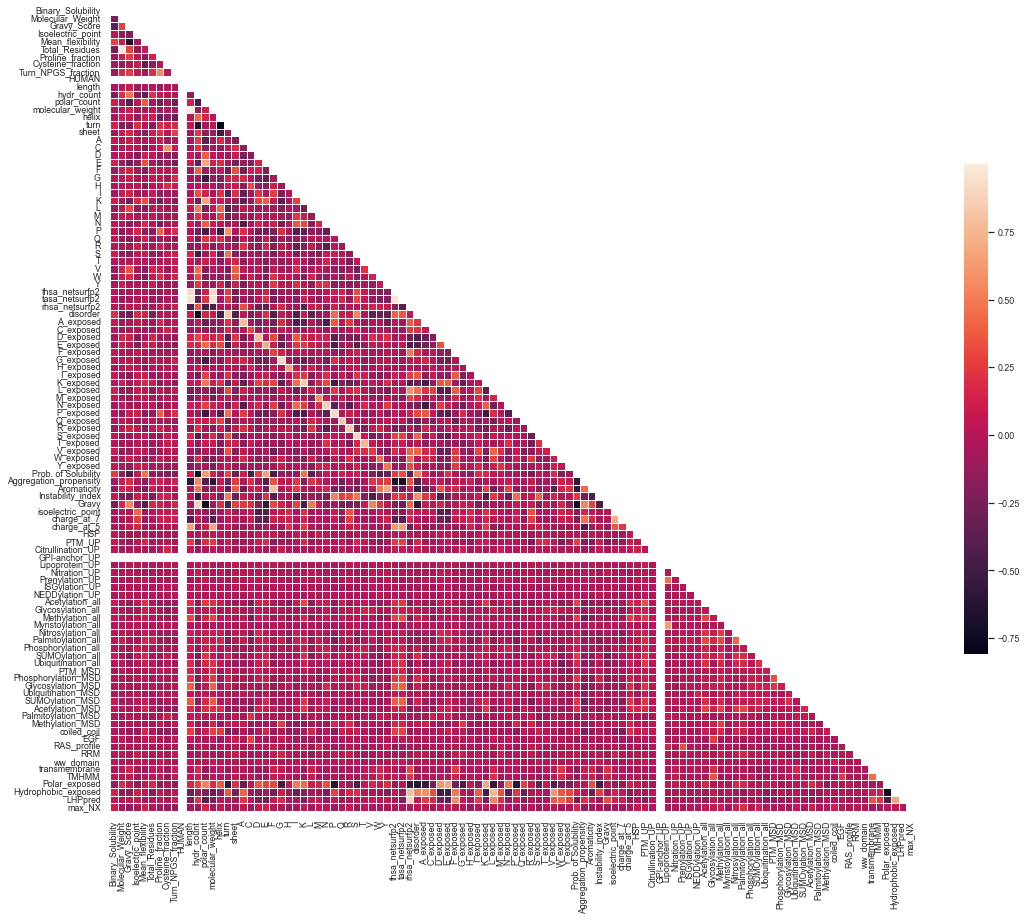

In [196]:
sns.set(font_scale=0.8)

mask = np.triu(np.ones_like(corr_all, dtype=bool))
sns.set_style(style = 'white')
fig, ax = plt.subplots(figsize=(18, 18))
cmap = sns.diverging_palette(10, 250, as_cmap=True)
sns.heatmap(corr_all, mask=mask, cmap="rocket", square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax,
            xticklabels=True, yticklabels=True);
plt.savefig('Figures/Correlations.png', dpi=300, bbox_inches='tight')


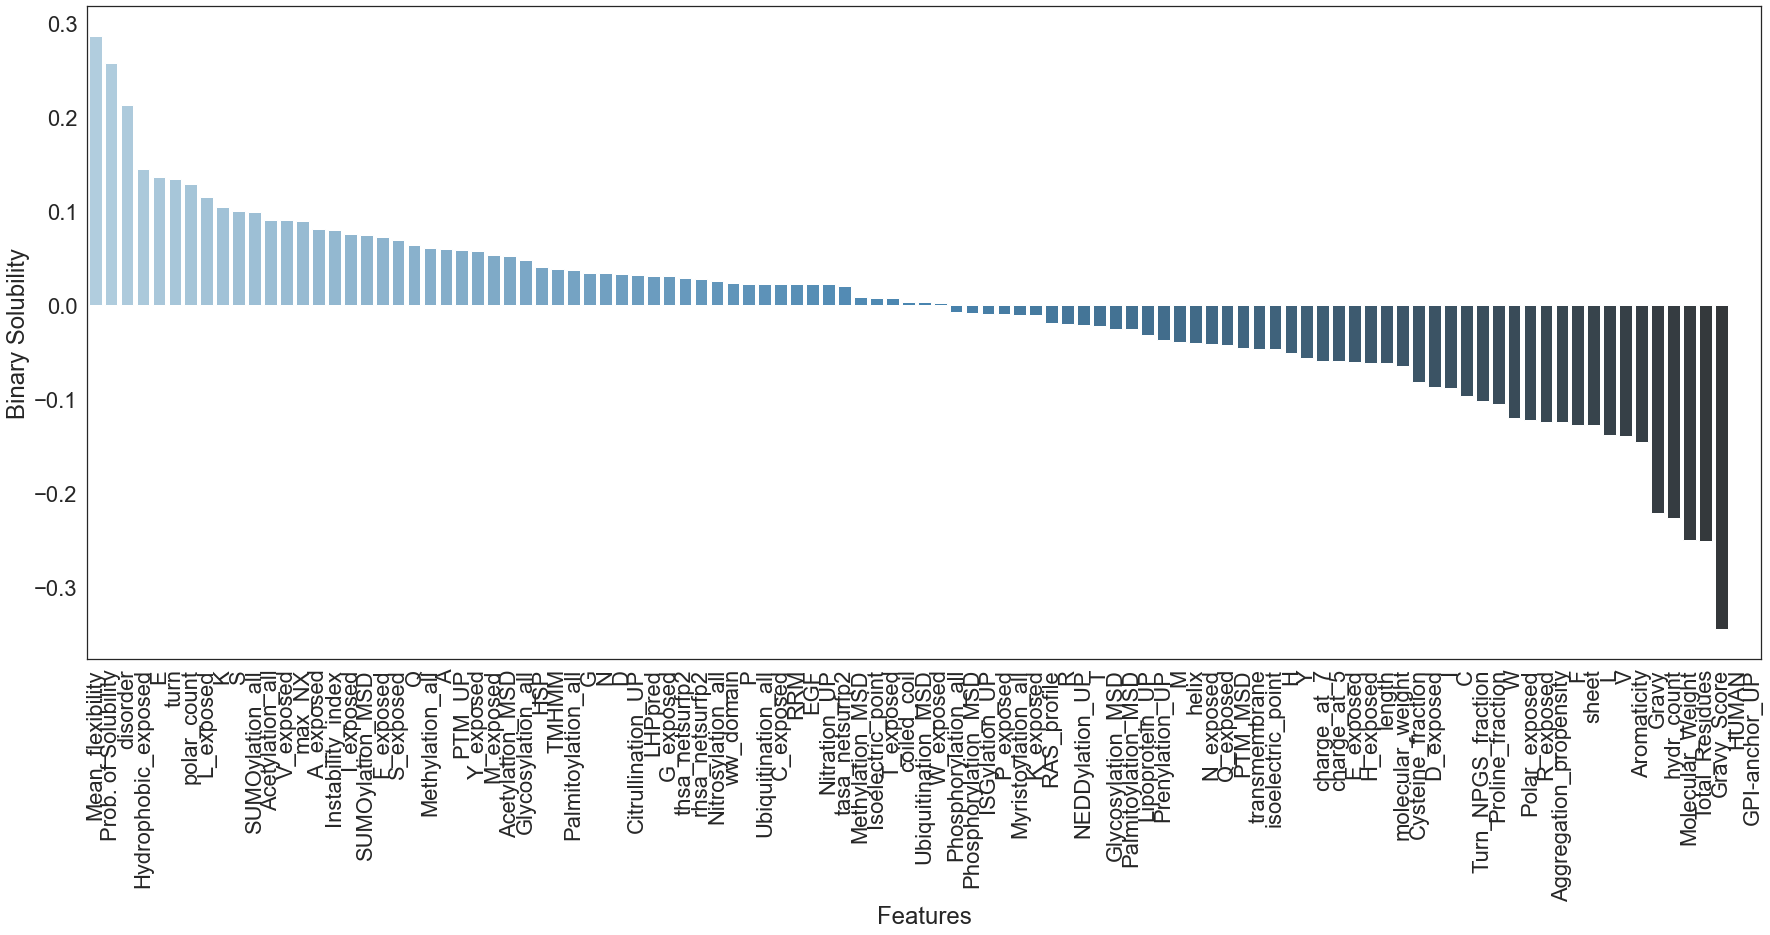

In [197]:
sns.set(style=("white"), font_scale=2)
sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True)
correlations_all = corr_all[["Binary_Solubility"]].sort_values(by="Binary_Solubility", ascending=False)[1:]
correlations_all.reset_index(inplace=True)

colors_all = ["b" if (x > 0) else "r" for x in correlations_all["Binary_Solubility"]]

fig = plt.figure(figsize=(30, 12)) 
sns.barplot(x="index", y="Binary_Solubility", data=correlations_all, palette="Blues_d")
plt.xlabel("Features") 
plt.ylabel("Binary Solubility") 
plt.xticks(rotation=90)
plt.savefig('Figures/featureCorrelation.png', dpi=300, bbox_inches='tight')

## Checking performance with SWI 

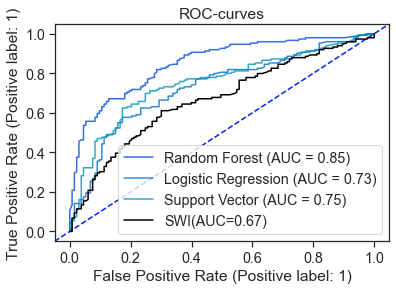

In [216]:
df_val_copy = get_normalised_df(df_val_copy)
sns.set(style=("ticks"),font_scale=1.3)
sns.set_palette("winter", desat=1)
fpr, tpr, _ = metrics.roc_curve(Test_labels2,  df_val_copy['Prob. of Solubility'])
ax = plt.gca()
ax.plot([0, 1], [0, 1],linestyle='--', transform=ax.transAxes)
rf_disp = plot_roc_curve(rf, Test_features2, Test_labels2,name='Random Forest', ax=ax, alpha=0.8)
lr_disp = plot_roc_curve(lr, Test_features2, Test_labels2,name='Logistic Regression', ax=ax, alpha=0.8)
svc_disp = plot_roc_curve(svc, Test_features2, Test_labels2,name='Support Vector', ax=ax, alpha=0.8)
auc = round(metrics.roc_auc_score(Test_labels2,  df_val_copy['Prob. of Solubility']), 2)
ax.plot(fpr,tpr, label="SWI(AUC="+str(auc)+")", color="black")
plt.legend()
plt.title('ROC-curves')
plt.savefig('Figures/ROCcomparing.png', dpi=300, bbox_inches='tight')
plt.show()

In [213]:
HP = features.merge(LP_pred, on='UniprotID', how='left')
HP = HP.merge(max_exp, on='UniprotID', how='left').reset_index()
HP.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)
final = HP['UniprotID']
HP = HP[seq_features[1:]]
HP = get_normalised_df(HP)
new_sol_pred = rf.predict_proba(HP)[:, 1]

[0.53344497 0.6639993  0.58208333 0.45699459 0.58075794 0.47792857
 0.51185548 0.61099512 0.61522222 0.52890995 0.53876984 0.59154509
 0.66580159 0.4097619  0.65738636 0.60152309 0.5155     0.67732215
 0.66599206 0.66644444 0.71790657 0.70562013 0.58132143 0.68788889
 0.61341667 0.68939683 0.61514735 0.69875    0.59717388 0.5509791
 0.68685714 0.649      0.5619127  0.57511508 0.61818254 0.47624603
 0.60265745 0.67429762 0.53233442 0.61313797 0.54034524 0.63844444
 0.76661905 0.61404035 0.59745238 0.46436905 0.6032381  0.68421212
 0.5444246  0.61027381 0.61192857 0.61514286 0.69177381 0.5596627
 0.54566445 0.5025     0.53227128 0.61887229 0.5233254  0.50570238
 0.51006494 0.55059524 0.53097583 0.56887013 0.49513217 0.5721627
 0.46224387 0.60161508 0.61896032 0.59727778 0.53221429 0.60826984
 0.55466117 0.50261294 0.48386508 0.51011508 0.51419841 0.5972619
 0.56802381 0.61133333 0.55015873 0.50272344 0.6365     0.61609524
 0.62434921 0.61699206 0.70780159 0.70621429 0.49132684 0.53491667

In [214]:
sns.displot( x=new_sol_pred)
sol_pred = pd.DataFrame(new_sol_pred)
sol_pred.columns = ['prob_of_sol']
print(len(sol_pred))
sol_pred = pd.concat([final, sol_pred], axis=1)
sol_pred.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)
sol_pred.reset_index()
sol_pred.to_csv('SolubilityPredictions.csv', index =False)

18834


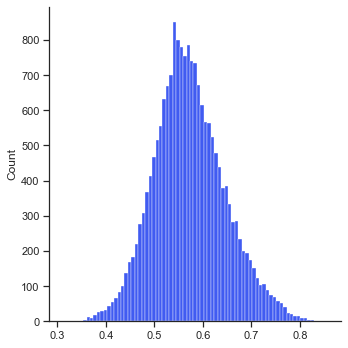

In [215]:
sns.displot( x=new_sol_pred)


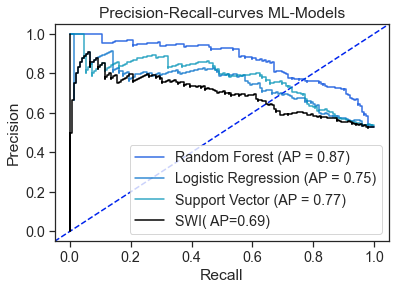

In [237]:
sns.set_palette("winter")
from sklearn.metrics import PrecisionRecallDisplay
prec, recall, _ = metrics.precision_recall_curve(Test_labels2,  df_val_copy['Prob. of Solubility'])
ax = plt.gca()
ax.plot([0, 1], [0, 1],linestyle='--', transform=ax.transAxes)
rf_disp = plot_precision_recall_curve(rf, Test_features2, Test_labels2,name='Random Forest', ax=ax, alpha=0.8)
lr_disp = plot_precision_recall_curve(lr, Test_features2, Test_labels2,name='Logistic Regression', ax=ax, alpha=0.8)
svc_disp = plot_precision_recall_curve(svc, Test_features2, Test_labels2,name='Support Vector', ax=ax, alpha=0.8)
ap = round(metrics.average_precision_score(Test_labels2,  df_val_copy['Prob. of Solubility']), 2)
pr_display =PrecisionRecallDisplay(precision=prec, recall=recall)
pr_display.plot(ax=ax, name="SWI( AP="+str(ap)+")", color = "black") 
plt.legend()
plt.title('Precision-Recall-curves ML-Models')
plt.savefig('Figures/PRcomparing.png', dpi=300, bbox_inches='tight')
plt.show()


## Redoing everything with only top 20 features:

In [55]:
top_20 = top_20["feature"].tolist()
top_20.append("Binary_Solubility")
new_df_top20 =original[top_20]

Final_DNASU_ML_top20 = get_normalised_df(new_df_top20)#TRAINING DATASET
df_train_top20, df_test_val_top20 = train_test_split(Final_DNASU_ML_top20, test_size=0.2)
df_test_top20, df_val_top20 = train_test_split(df_test_val_top20, test_size=0.5)
df_train_top20 =df_train_top20.reset_index(drop=True)
df_test_top20 = df_test_top20.reset_index(drop=True)
df_val_top20 = df_val_top20.reset_index(drop=True)


In [56]:
#Labels are the values to be predicted, in this case the solubility
Train_labels_top20 = np.array(df_train_top20['Binary_Solubility'])

# Remove the labels from the features
Train_features_top20= df_train_top20.drop('Binary_Solubility', axis = 1)

# Saving feature names for later use
Train_feature_list_top20 = list(Train_features_top20.columns)

# Convert to numpy array
Train_features_top20 = np.array(Train_features_top20)
# Train_features = RobustScaler().fit_transform(Train_features)


#Same thing for test set
Test_labels_top20 = np.array(df_test_top20['Binary_Solubility'])
Test_features_top20 = df_test_top20.drop('Binary_Solubility', axis = 1)
Test_feature_list_top20 = list(Test_features_top20.columns)
Test_features_top20 = np.array(Test_features_top20)
# Test_features = RobustScaler().fit_transform(Test_features)

#And the cleaned test set
Test_labels2_top20 = np.array(df_val_top20['Binary_Solubility'])
Test_features2_top20 = df_val_top20.drop('Binary_Solubility', axis = 1)
Test_feature_list2_top20 = list(Test_features2_top20.columns)
Test_features2_top20 = np.array(Test_features2_top20)
# Test_features2 = RobustScaler().fit_transform(Test_features2)

#Check shape of train and test
print('Training Features Shape:', Train_features_top20.shape)
print('Training Labels Shape:', Train_labels_top20.shape)
print('Testing Features Shape:', Test_features_top20.shape)
print('Testing Labels Shape:', Test_labels_top20.shape)
print('Cleaned testing Features Shape:', Test_features2_top20.shape)
print('Cleaned testing Labels Shape:', Test_labels2_top20.shape)


Training Features Shape: (2252, 50)
Training Labels Shape: (2252,)
Testing Features Shape: (282, 50)
Testing Labels Shape: (282,)
Cleaned testing Features Shape: (282, 50)
Cleaned testing Labels Shape: (282,)


In [57]:
#Support vector
svc_top20 = SVC(random_state=42)
svc_top20.fit(Train_features_top20, Train_labels_top20)

#random forest
rf_top20 = RandomForestClassifier(n_estimators = 100, bootstrap = True, max_features = 'sqrt')
rf_top20.fit(Train_features_top20, Train_labels_top20)

#Logistic regression
lr_top20 = LogisticRegression(max_iter = 1000)
lr_top20.fit(Train_features_top20, Train_labels_top20)

LogisticRegression(max_iter=1000)

In [58]:
# Use the forest's predict method on the test data
rf_predictions_top20 = rf_top20.predict(Test_features_top20)

# Probabilities for each class
rf_probs_top20 = rf_top20.predict_proba(Test_features_top20)[:, 1]

#same for cleaned test set
rf_predictions2_top20 = rf_top20.predict(Test_features2_top20)
rf_probs2_top20 = rf_top20.predict_proba(Test_features2_top20)[:, 1]

In [59]:
# Calculate roc auc 
roc_value = roc_auc_score(Test_labels_top20, rf_probs)
print('AUC:', roc_value)

#same for cleaned
roc_value = roc_auc_score(Test_labels2_top20, rf_probs2)
print('AUC:', roc_value)

AUC: 0.47874427730542835
AUC: 0.44011930640513625


In [60]:
# Extract feature importances
fi_top20 = pd.DataFrame({'feature': (Train_feature_list_top20),
                   'importance': rf_top20.feature_importances_}).\
                    sort_values('importance', ascending = False)

# Display
fi_top20

,feature,importance
35,K,0.036270
49,turn,0.033106
36,length,0.031531
46,L,0.030310
43,Hydrophobic_exposed,0.029553
41,max_NX,0.029390
48,I,0.029170
19,Polar_exposed,0.027015
17,S,0.026112
39,charge_at_5,0.025464


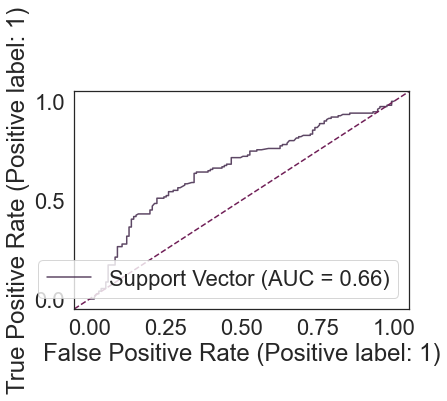

In [61]:
sns.set_palette("rocket")
ax = plt.gca()
svc_disp2 = plot_roc_curve(svc_top20, Test_features2_top20, Test_labels2_top20,name='Support Vector', ax=ax, alpha=0.8)
ax.plot([0, 1], [0, 1],linestyle='--', transform=ax.transAxes)
plt.show()

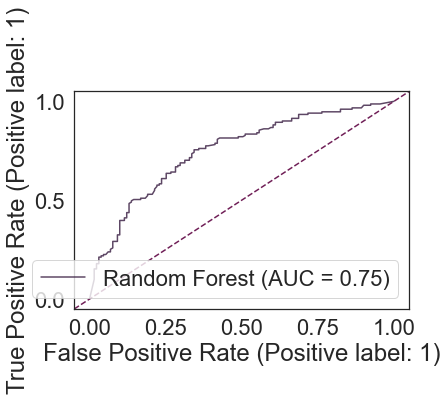

In [62]:
ax = plt.gca()
rf_disp2 = plot_roc_curve(rf_top20, Test_features2_top20, Test_labels2_top20,name='Random Forest', ax=ax, alpha=0.8)
ax.plot([0, 1], [0, 1],linestyle='--', transform=ax.transAxes)
plt.show()

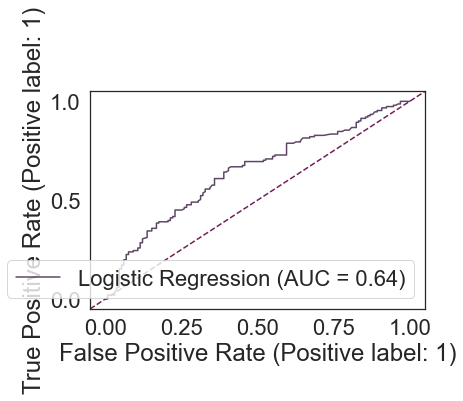

In [63]:
ax = plt.gca()
svc_disp2 = plot_roc_curve(lr_top20, Test_features2_top20, Test_labels2_top20,name='Logistic Regression', ax=ax, alpha=0.8)
ax.plot([0, 1], [0, 1],linestyle='--', transform=ax.transAxes)
plt.show()

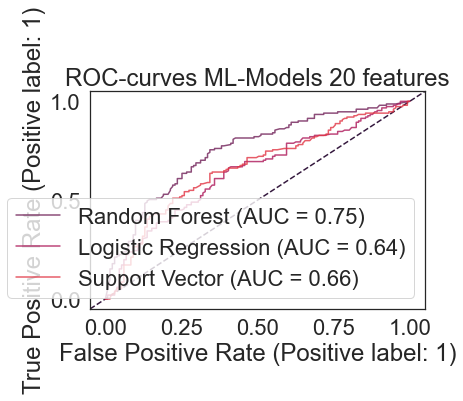

In [64]:
ax = plt.gca()
ax.plot([0, 1], [0, 1],linestyle='--', transform=ax.transAxes)
rf_disp = plot_roc_curve(rf_top20, Test_features2_top20, Test_labels2_top20,name='Random Forest', ax=ax, alpha=0.8)
lr_disp = plot_roc_curve(lr_top20, Test_features2_top20, Test_labels2_top20,name='Logistic Regression', ax=ax, alpha=0.8)
svc_disp = plot_roc_curve(svc_top20, Test_features2_top20, Test_labels2_top20,name='Support Vector', ax=ax, alpha=0.8)
plt.title('ROC-curves ML-Models 20 features')
plt.show()

In [65]:
from sklearn.model_selection import train_test_split
SOLtarget = np.array(df_train['Binary_Solubility'])
SOLdata = np.array(Train_features)

In [66]:
from sklearn.model_selection import StratifiedKFold
kf = StratifiedKFold(n_splits = 10)

In [67]:
AUC_rf = []
for train_index,test_index in kf.split(SOLdata, SOLtarget):
    x_train, x_test, y_train, y_test = SOLdata[train_index], SOLdata[test_index], \
                                        SOLtarget[train_index], SOLtarget[test_index]
    model = LogisticRegression(max_iter = 1000)
    AUC_rf.append(get_AUC(model, x_train, x_test, y_train, y_test))
print("Mean AUC score:")
print(np.mean(AUC_rf))

Mean AUC score:
0.6601589173405211


In [68]:
print(np.mean(cross_val_score(LogisticRegression(max_iter = 1000),SOLdata,SOLtarget,scoring= 'roc_auc',cv=10)))
print(np.mean(cross_val_score(SVC(),SOLdata,SOLtarget,scoring= 'roc_auc',cv=10)))
print(np.mean(cross_val_score(RandomForestClassifier(n_estimators = 100),SOLdata,SOLtarget,scoring= 'roc_auc',cv=10)))

0.6601589173405211
0.693370820340715
0.7668322873174427


In [69]:
# LR2 = cross_val_score(LogisticRegression(max_iter = 10000),SOLdata,SOLtarget,scoring= 'roc_auc',cv=10)
# SVM2 = cross_val_score(SVC(),SOLdata,SOLtarget,scoring= 'roc_auc',cv=10)
# RF2 = cross_val_score(RandomForestClassifier(n_estimators = 100),SOLdata,SOLtarget,scoring= 'roc_auc',cv=10)

# mean_LR2 = np.mean(LR)
# mean_SVM2 = np.mean(SVM)
# mean_RF2 = np.mean(RF)

# std_LR2 = np.std(LR)
# std_SVM2 = np.std(SVM)
# std_RF2 = np.std(RF)


# labels = ['Logistic Regression', 'Support Vector Machine', 'Random Forest']
# x_pos = [1,2,3]

# means2 = [mean_LR2, mean_SVM2, mean_RF2]
# stds2 = [std_LR2, std_SVM2, std_RF2]

# fig, ax = plt.subplots()
# ax.bar(x_pos, means2, yerr=stds2, align='center', ecolor='black',alpha = 0.5, capsize=15, color="purple")
# ax.set_xticks(x_pos)
# ax.set_xticklabels(labels)
# ax.set_title("10-fold cross-validation")
# ax.yaxis.grid(True)
# plt.savefig('Figures/10FoldBarplot2.png', dpi=300, bbox_inches='tight')


In [70]:
labels = ['LR', 'SVM','RF', 'LR_top20','SVM_top20','RF_top20']

means3 = [mean_LR, mean_SVM,mean_RF, mean_LR2,mean_SVM2,mean_RF2]
stds3 = [std_LR, std_SVM, std_RF,std_LR2, std_SVM2, std_RF2]
x_pos = [1, 1.8, 2.6, 4,4.8 ,5.6]
colors= ["lightblue","blue", "darkblue","plum", "violet","purple"]
fig, ax = plt.subplots()
ax.bar(x_pos, means3, yerr=stds3, align='center', ecolor='black',alpha = 0.6, capsize=15, color=colors)
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
ax.set_title("10-fold cross-validation")
ax.yaxis.grid(True)
plt.savefig('Figures/10FoldBarplot3.png', dpi=300, bbox_inches='tight')




NameError: name 'mean_LR' is not defined

In [ ]:
d = {'Model': ['Logistic Regression', 
                   'Support Vector', 'Random Forest'],
        'AUC':[0.7579517511407079, 0.7778397063227807, 0.8449512028081674]}
df = pd.DataFrame(data=d)

In [ ]:
# sns.set(style=("ticks"), font_scale=1.5)
sns.set_palette("rocket")
ax = sns.barplot(x="AUC", y="Model", data=df, ).set_title('Mean 10-fold cross-validation score for 20 features')